<a href="https://colab.research.google.com/github/ksydata/MiraeAssetHackathon/blob/main/%5Bmarket_index_data%5D_1_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0.코드북 기반 데이터 전처리

#### 0-1) 필요한 모듈 불러오기

In [1]:
# 코랩에 구글 드라이브 마운트
from google.colab import drive
drive.mount("/content/drive")

# 데이터 처리 모듈
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

# 멀티프로세싱
import multiprocessing as mp

# 척도 변환 모듈(표준화, 정규화, 로버스트 정규화, 원핫인코딩(범주형에서 더미변수로 변환) 등)
from sklearn.preprocessing import *

# 결측값 관측 모듈
import missingno as msno

# 시각화 모듈
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# 배열, 행렬 연산 모듈
import numpy as np

# 데이터 분할 모듈(훈련용 / 검증용 / 시험용)
from sklearn.model_selection import train_test_split

# 통계적 가설검정 및 계량화 모듈
import statsmodels.api as sm
import statsmodels.tsa.api as smt#
# https://youtu.be/FtWEZw3kUho

# 타입 어노테이션 모듈
from typing import *

# 시간 관련 모듈
from tqdm import tqdm
import time
  # time.sleep(2)

# 웹크롤링 / 스크래핑 관련 모듈
import requests
import io
import zipfile
from bs4 import BeautifulSoup
from xml.etree import ElementTree as ET

# 결측값 대체
from sklearn.impute import KNNImputer

Mounted at /content/drive


#### 0-2) 데이터 상세 기반 문제 정의 및 기획 방향 설정 | 탐색적 데이터 분석(EDA)

In [3]:
class LoadData():

# 클래스(로컬공간) 내부에서 cs_data, apy_itm_hist_dat, market_index_data의 값
# 생성자를 활용하여 초기화하고 클래스 내부에 캡슐화
  def __init__(self,
               cs_data_path: str, apy_itm_hist_path: str, market_index_path: str):
    # 용량이 큰 csv 파일 읽어오기(fopen - fread와 유사한 방식)
    cs_chunk = pd.read_csv(cs_data_path, chunksize = 10**5, index_col = False, na_values = "NaN", encoding = "utf-8")
    self.cs_data = list(cs_chunk)
    self.apy_itm_hist_data = pd.read_csv(apy_itm_hist_path, index_col = False, na_values = "NaN", encoding = "utf-8")
      # [BAS_YM] (19.12 ~ 23.04) 기준연월
      # [APY_ITM] (19.12 ~ 23.04)간 공모주 청약 진행된 종목 번호
      # [APY_FIN_YM] 이전 3년(19.12 ~ 22.11)간 마지막으로 참여한 공모주 청약연월(X)
      # [APY_ITM_CNT] 이전 3년(19.12 ~ 22.11)간 공모주 청약에 참여한 종목 개수(X)
    self.market_index_data = pd.read_csv(market_index_path, index_col = False, na_values = "NaN", encoding = "utf-8")


# parallelDataFrame()
# csv(쉼표로 분할된) 데이터 로드 시 병렬처리하는 메서드
# 실제로 수행할 정도로 데이터 크기가 크지는 않고 100,000행씩 chunking하면 해결됨
  def parallelDataFrame(self, data, function):
    # 코어 수 확인(multiprocessing as mp)
    mp.cpu_count()
    # 코어 수를 전역변수 선언
    global num_cores
    # 코어 수만큼 입력받은 데이터를 2차원 배열로 분할하여 멀티프로세싱(병렬처리)
    data_split = np.array_split(data, num_cores)
    # 코어 수만큼 pool을 생성
    pool = mp.Pool(num_cores)
    # 나누어진 데이터를 function으로 넘겨서 병렬처리 수행
    data = pd.concat(pool.map(
        function, iterable = data_split))
    pool.close()
    # 모두 완료될 때까지 대기
    pool.join
    return data


# loadData()
# 불러온 데이터를 반환(코드 구현 시 활용하고 나중에는 제거할 메서드)
  def loadData(self):
    return self.cs_data, self.apy_itm_hist_data, self.market_index_data

In [4]:
DataInstance = LoadData(
    cs_data_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/cs_data.csv",
    apy_itm_hist_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/apy_itm_hist.csv",
    market_index_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/mkt_idx.csv"
)
  # [참고] 경로 너무 길어지니까 겹치는 경로는 os.path.join 활용하여 반복 줄일 수 있음

<ipython-input-3-4375fd47f4ef>:9: DtypeWarning: Columns (33,34,35,64,65,66,95,96,97,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  self.cs_data = list(cs_chunk)
<ipython-input-3-4375fd47f4ef>:9: DtypeWarning: Columns (33,34,35,64,65,66,95,96,97,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  self.cs_data = list(cs_chunk)
<ipython-input-3-4375fd47f4ef>:9: DtypeWarning: Columns (33,34,35,64,65,66,95,96,97,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  self.cs_data = list(cs_chunk)
<ipython-input-3-4375fd47f4ef>:9: DtypeWarning: Columns (33,34,35,64,65,66,95,96,97,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  self.cs_data = list(cs_chunk)
<ipython-input-3-4375fd47f4ef>:9: DtypeWarning: Columns (33,34,35,64,65,66,95,96,97,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  self.cs_data = 

In [5]:
cs_data, apy_itm_hist, market_index = DataInstance.loadData()

In [6]:
cs_merge_data = pd.concat(cs_data)
  # [참고] 텍스트 파일로 저장해도 1.23GB 용량은 줄지 않는바 수행하지 않음
  # cs_merge_data.to_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/cs_data.txt", index = False)

In [ ]:
cs_merge_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803308 entries, 0 to 803307
Columns: 522 entries, AGE_TCD to HTS_DYS_M4_3
dtypes: float64(325), int64(2), object(195)
memory usage: 3.1+ GB


In [ ]:
_, column_length = cs_merge_data.shape

# 총 552개 컬럼(dtypes: float64(325), int64(2), object(195))으로
# 컬럼별 타입 및 결측값 확인 반복문 수행 필요
for index in range(0, column_length, 50):
    cs_merge_data.iloc[:, index : index + 50].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803308 entries, 0 to 803307
Data columns (total 50 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   AGE_TCD              803308 non-null  int64  
 1   CS_GCD_BEF           803308 non-null  object 
 2   CS_GCD_AFT           803308 non-null  object 
 3   MT_EP_EXIST_YN       803308 non-null  object 
 4   LST_BEST_EA          803308 non-null  float64
 5   LST_BEST_YM          803308 non-null  int64  
 6   DMST_FST_BUY_YM      779988 non-null  float64
 7   DMETF_FST_BUY_YM     262798 non-null  float64
 8   OVST_FST_BUY_YM      181130 non-null  float64
 9   OVETF_FST_BUY_YM     109700 non-null  float64
 10  DMST_FIN_BUY_YM      779988 non-null  float64
 11  DMETF_FIN_BUY_YM     262798 non-null  float64
 12  OVST_FIN_BUY_YM      181130 non-null  float64
 13  OVETF_FIN_BUY_YM     109700 non-null  float64
 14  DMST_TR_MONTHS_CNT   787442 non-null  float64
 15  DMETF_TR_MONTHS_C

<Axes: >

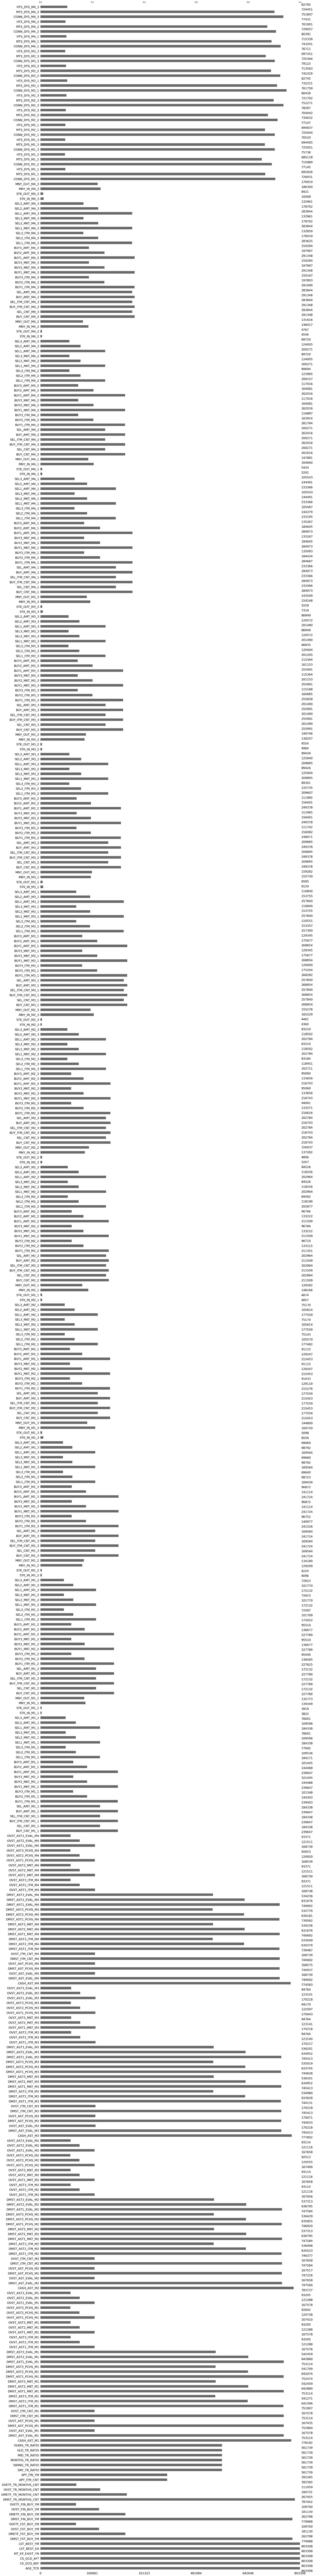

In [ ]:
msno.bar(cs_merge_data)
  # [참고] 데이터 상세상 0과 결측(NULL)의 구분이 없다는 점에서
  # 함부로 결측값을 예측모델로 대체하면 안됨

In [ ]:
# def main():
# if __name__ == "__main__" : main()

___

In [ ]:
market_index

,BAS_DT,DOW,NASDAQ,SP500,KOSPI,KOSDAQ
0,20221201,34395.011719,11482.450195,4076.570068,2479.84,740.60
1,20221202,34429.878906,11461.500000,4071.699951,2434.33,732.95
2,20221205,33947.101562,11239.940430,3998.840088,2419.32,733.32
3,20221206,33596.339844,11014.889648,3941.260010,2393.16,719.44
4,20221207,33597.921875,10958.549805,3933.919922,2382.81,718.14
...,...,...,...,...,...,...
102,20230424,33875.398438,12037.200195,4137.040039,2523.50,855.23
103,20230425,33530.828125,11799.160156,4071.629883,2489.02,838.71
104,20230426,33301.871094,11854.349609,4055.989990,2484.83,830.44
105,20230427,33826.160156,12142.240234,4135.350098,2495.81,850.21


In [24]:
class ExplolatoryDataAnalysis():

# Child 클래스내에 Parent 클래스의 메소드를 모두 가져오기
  def __init__(self, market_index_data: pd.DataFrame(), date_column: str,
               TimeSeries_method_return = None, Impute_method_return = None):

    self.market_index_data = market_index_data
    self.date_column = date_column
    self.TimeSeries_method_return = TimeSeries_method_return
    self.Impute_method_return = Impute_method_return
      # super().__init__(market_index)
      # super(파생클래스이름, self).__init__()
      # super(ClassName, self).__init__(**kwargs)


# timeSeriesPreprocessing()
  # 클래스 메소드의 큰 특징은, 첫 번째 인수로 객체가 넘어오는 게 아니라, 클래스가 넘어오게(@classmethod)
  # 1. 날짜형 타입 변환
  def timeSeriesPreprocessing(self):

    self.market_index_data[self.date_column] = self.market_index_data[self.date_column].astype("str")
    self.market_index_data[self.date_column] = self.market_index_data[self.date_column].apply(lambda x: datetime.datetime.strptime(x, "%Y%m%d"))

    if self.date_column in self.market_index_data.columns:
      # date_column(입력받은 날짜형 컬럼명)이 시장지수데이터의 컬럼 내 있다면
      self.market_index_data["DateTime"] = pd.to_datetime(self.market_index_data[self.date_column])
        # date_column을 DateTime이라는 날짜형 변수로 생성
    if self.market_index_data.index.dtype == "int64":
      # 인덱스 타입이 64비트 정수형이면, DateTime 컬럼으로 변경
      self.market_index_data.set_index("DateTime", inplace = True)
    self.market_index_data.drop([self.date_column], axis = 1, inplace = True)

    self.TimeSeries_method_return = self.market_index_data


# ImputeNotAvailableValue()
  # 2. 시계열 결측값 DOW(5) | NASDAQ(5) | SP500(5) | KOSPI(4) | KOSDAQ(4)
  def ImputeNotAvailableValue(self):

    KNN_NaN_Imputer = KNNImputer(n_neighbors = 5)
    self.market_index_data = pd.DataFrame(
        KNN_NaN_Imputer.fit_transform(self.market_index_data),
        index = self.market_index_data.index,
        columns = self.market_index_data.columns)

    self.Impute_method_return = self.market_index_data


# reviewNaN()
  # 3. 결측값이 K최근접 이웃 거리 기반 대체 시 어떻게 채워졌는지
  # 날짜와 시간의 간격을 2일로 두고 결측이었던 행 출력
  def reviewNaN(self):
    for col_name in self.TimeSeries_method_return.columns:
      nan_matrix = self.TimeSeries_method_return[col_name].isnull()
      print(self.TimeSeries_method_return[nan_matrix])


    for index in [
        "2022-12-26", "2022-12-30",
        "2023-01-02", "2023-01-16", "2023-01-23", "2023-01-24",
        "2023-02-20", "2023-03-01", "2023-04-07"]:
        index = str(index).replace("-","")
        before = datetime.datetime.strptime(index, "%Y%m%d") - relativedelta(days = 2)
        after = datetime.datetime.strptime(index, "%Y%m%d") + relativedelta(days = 3)

      # TypeError: unsupported operand type(s) for -: 'str' and 'datetime.timedelta'
      # datetime.datetime.strptime(index, "%Y%m%d")
        before = str(before).replace(" 00:00:00", "")
        after = str(after).replace(" 00:00:00", "")
        self.TimeSeries_method_return.index = self.TimeSeries_method_return.index.astype("str")

        print(
            self.TimeSeries_method_return.loc[before:after, :], "\n",
            self.Impute_method_return.loc[before:after, :], "\n")


# timeSeriesDecomposition()
  # 4. 시계열 분해 : 추세 + 계절성 + 잔차 or 추세 * 계절성 * 잔차
  def timeSeriesDecomposition(self, indice: str, decompose_method: str):
  # [decompose_method] additive, multicative
    decomposition = sm.tsa.seasonal_decompose(
        self.market_index_data[indice],
        model = decompose_method )

  # 4.1) 추세 : 시간에 따라 증감 또는 일정 수준을 유지하는 것(확률과정의 결정론적 기댓값 함수를 알아내는 것)
  # 확률과정 Y_t이 추정이 가능한 결정론적 추세함수 f(t)와 정상확률과정 Y_t^s의 합
  # Y_t = f(t) + Y_t^s
    indice_trend = pd.DataFrame(decomposition.trend)
    indice_trend.fillna(method = "ffill", inplace = True)
    indice_trend.fillna(method = "bfill", inplace = True)
    indice_trend.columns = ["TREND"]

  # 4.2) 계절성 : 일정한 빈도로 반복되는 패턴, 특정 월/요일에 따라 기댓값이 달라지는 것
    indice_seasonal = pd.DataFrame(decomposition.seasonal)
    indice_seasonal.fillna(method = "ffill", inplace = True)
    indice_seasonal.fillna(method = "bfill", inplace = True)
    indice_seasonal.columns = ["SEASONAL"]

    if "TREND" not in self.market_index_data.columns:
      if "SEASONAL" not in self.market_index_data.columns:
        self.market_index_data = pd.concat(
            [self.market_index_data, indice_trend, indice_seasonal], axis = 1 )

    return self.market_index_data

  # 4.3) 특정 시점을 기준으로 전후 12일씩 총 24일간의 이동평균된 pandas Series타입
  # Y_day = dataframe[[Y]].rolling(24).mean()
  # Y_week = dataframe[[Y]].rolling(24 * 7).mean()


# StationaryADFTest()
# 5. 시계열의 정상성(Stationarity) 검정 : 관측된 시간과 시계열의 특징은 무관할까
# Ha : 시계열에 단위근이 존재하지 않는다. (시계열이 정상성을 만족한다)
# https://www.statsmodels.org/dev/_modules/statsmodels/tsa/stattools.html#adfuller
  def StationaryADFTest(self, Y_data):

      stationary_adf = pd.Series(
        sm.tsa.stattools.adfuller(Y_data.values)[0:4],
        index = ["Test Statistics", "p-value", "Used Lag", "Used Observations"])
          # y_t = a_1*y_t-1 + a_2*y_t-2 + ... + e_t
          # [단위근(unit root)] t시점의 확률변수는 t-1, t-2, ... 시점의 확률변수와 관계가 있으며 에러가 포함되는 것
          # m**p - m**(p-1)*a_1 - m**(p-2)*a_2 - ... - a_p = 0
          # [m = 1] 위 식의 근이 되는 m = 1이면 시계열 확률 과정은 단위근을 가진다고 말한다.
          # 그렇지 않다면, 약정상성을 띠는 t시점 시계열 데이터는 확률 과정의 성질(E(Xt), Var(Xt))이 변하지 않는다.

      for key, value in sm.tsa.stattools.adfuller(Y_data.values)[4].items():
        stationary_adf["Critical Values(%s)"%key] = value
        stationary_adf["Maximum Information Criteria"] = sm.tsa.stattools.adfuller(Y_data.values)[5]
        stationary_adf = pd.DataFrame(
            stationary_adf, columns = ["stationarity_adf"])

      return stationary_adf


# AutoCorrelation
# 6. 시계열(시차)의 자기상관성 검정(Null Hypothesis: Autocorrelation is absent) : lag(시차) 1일, 5일, 10일, 50일
  def AutoCorrelation(self, Y_data):
    auto_correlation = pd.DataFrame(
        sm.stats.diagnostic.acorr_ljungbox(Y_data.values, lags = [1, 5, 10, 50])
    ).T
    auto_correlation.columns = [
        "자기상관(1일의 시차)", "자기상관(5일의 시차)", "자기상관(10일의 시차)", "자기상관(50일의 시차)"]
    auto_correlation.index = [
        "검정통계량", "유의확률(p-value)"]

    display(auto_correlation)


# timeSeriesDifferencing()
# 7. 정상성(stationarity)을 나타내지 않는 시계열의 정상성을 나타내도록, 추세나 계절성을 완화하는 차분
  # 시계열의 수준에서 나타나는 변화를 제거하여 시계열의 평균 변화를 일정하게 만드는데 도움이 된다.
  # 다시 말해 비정상적 시계열은 누적 과정(integrated procss)이기 때문에 발생할 수 있다.

  # [관측값의 차이, 차분] y_t = y_{t-1} + e_t
  # [2차 차분] ( y_t - y_{t-1} ) - ( y_{t-1} - y_{t-2} )
  # 2차 이상의 차분을 한 데이터로 적합한 모델의 설명력이 낮아질 수 있다.
  # [계절성 차분] y_t - y_{t-m} (단, m은 계절 수)
  def timeSeriesDifferencing(self, dataframe, indice):

    Y_differencing = dataframe[[indice]].diff()
    Y_differencing.fillna(method = "ffill", inplace = True)
    Y_differencing.fillna(method = "bfill", inplace = True)
    Y_differencing.columns = ["y_difference"]
    # if "y_difference" not in dataframe.columns: dataframe = pd.concat([dataframe, Y_differencing], axis = 1)
    return Y_differencing


# timeSeriesFinalData()
  def timeSeriesFinalData(self):

    Differencing_method_return = pd.DataFrame()
    self.market_index_data.info()
    for col_name in self.market_index_data.columns:
      Differencing_method_return[col_name] = self.timeSeriesDifferencing(
          dataframe = self.market_index_data, indice = col_name)

    return Differencing_method_return

In [25]:
EDA = ExplolatoryDataAnalysis(
    market_index_data = market_index,
    date_column = "BAS_DT")
  # ValueError: This function does not handle missing values

In [9]:
EDA.timeSeriesPreprocessing()

In [10]:
EDA.ImputeNotAvailableValue()

In [11]:
EDA.reviewNaN()

            DOW  NASDAQ  SP500    KOSPI  KOSDAQ
DateTime                                       
2022-12-26  NaN     NaN    NaN  2317.14  694.68
2023-01-02  NaN     NaN    NaN  2225.67  671.51
2023-01-16  NaN     NaN    NaN  2399.86  716.89
2023-02-20  NaN     NaN    NaN  2455.12  788.89
2023-04-07  NaN     NaN    NaN  2490.41  880.07
            DOW  NASDAQ  SP500    KOSPI  KOSDAQ
DateTime                                       
2022-12-26  NaN     NaN    NaN  2317.14  694.68
2023-01-02  NaN     NaN    NaN  2225.67  671.51
2023-01-16  NaN     NaN    NaN  2399.86  716.89
2023-02-20  NaN     NaN    NaN  2455.12  788.89
2023-04-07  NaN     NaN    NaN  2490.41  880.07
            DOW  NASDAQ  SP500    KOSPI  KOSDAQ
DateTime                                       
2022-12-26  NaN     NaN    NaN  2317.14  694.68
2023-01-02  NaN     NaN    NaN  2225.67  671.51
2023-01-16  NaN     NaN    NaN  2399.86  716.89
2023-02-20  NaN     NaN    NaN  2455.12  788.89
2023-04-07  NaN     NaN    NaN  2490.41 

In [ ]:
DOW_EDA = EDA.timeSeriesDecomposition(
    indice = "DOW", decompose_method = "multicative")
NASDAQ_EDA = EDA.timeSeriesDecomposition(
    indice = "NASDAQ", decompose_method = "multicative")
SP500_EDA = EDA.timeSeriesDecomposition(
    indice = "SP500", decompose_method = "multicative")
KOSPI_EDA = EDA.timeSeriesDecomposition(
    indice = "KOSPI", decompose_method = "multicative")
KOSDAQ_EDA = EDA.timeSeriesDecomposition(
    indice = "KOSDAQ", decompose_method = "multicative")

In [ ]:
market_index_decomposition = pd.DataFrame()
for indice in [DOW_EDA, NASDAQ_EDA, SP500_EDA, KOSPI_EDA, KOSDAQ_EDA]:
  market_index_decomposition = pd.concat(
      [market_index_decomposition, indice[["TREND", "SEASONAL"]]], axis = 1)
# market_index_decomposition = pd.concat([market_index, market_index_decomposition], axis = 1)

for indice in [DOW_EDA, NASDAQ_EDA, SP500_EDA, KOSPI_EDA, KOSDAQ_EDA]:
  plt.plot(indice["TREND"])
  plt.show()
  plt.plot(indice["SEASONAL"])
  plt.show()

In [28]:
# 단위근 검정(정상성)
for col_name in market_index.columns:
  print(
      col_name, "\n",
      EDA.StationaryADFTest(Y_data = DOW_EDA[col_name]), "\n")

# 자기상관 검정(시간의 흐름에 따라 독립적이지 않다)
for col_name in market_index.columns:
  print(
      col_name, "\n",
      EDA.AutoCorrelation(Y_data = DOW_EDA[col_name]), "\n")

DOW 
                               stationarity_adf
Test Statistics                      -2.523928
p-value                               0.109760
Used Lag                              0.000000
Used Observations                   106.000000
Critical Values(1%)                  -3.493602
Maximum Information Criteria       1312.613191 

NASDAQ 
                               stationarity_adf
Test Statistics                      -1.046685
p-value                               0.735859
Used Lag                              0.000000
Used Observations                   106.000000
Critical Values(1%)                  -3.493602
Maximum Information Criteria       1197.032120 

SP500 
                               stationarity_adf
Test Statistics                      -1.779301
p-value                               0.390785
Used Lag                              0.000000
Used Observations                   106.000000
Critical Values(1%)                  -3.493602
Maximum Information Criteria     

,자기상관(1일의 시차),자기상관(5일의 시차),자기상관(10일의 시차),자기상관(50일의 시차)
검정통계량,8.527534e+01,2.876031e+02,3.948689e+02,7.810280e+02
유의확률(p-value),2.595807e-20,4.627228e-60,1.163120e-78,6.854429e-132


DOW 
 None 



,자기상관(1일의 시차),자기상관(5일의 시차),자기상관(10일의 시차),자기상관(50일의 시차)
검정통계량,1.001916e+02,4.369366e+02,7.409639e+02,9.254547e+02
유의확률(p-value),1.383479e-23,3.227346e-92,1.002960e-152,1.730735e-161


NASDAQ 
 None 



,자기상관(1일의 시차),자기상관(5일의 시차),자기상관(10일의 시차),자기상관(50일의 시차)
검정통계량,9.108332e+01,3.464012e+02,5.197851e+02,9.490307e+02
유의확률(p-value),1.377481e-21,1.042050e-72,2.604801e-105,2.401035e-166


SP500 
 None 



,자기상관(1일의 시차),자기상관(5일의 시차),자기상관(10일의 시차),자기상관(50일의 시차)
검정통계량,9.805827e+01,4.083167e+02,6.034794e+02,7.295636e+02
유의확률(p-value),4.062508e-23,4.782546e-86,3.163751e-123,2.008363e-121


KOSPI 
 None 



,자기상관(1일의 시차),자기상관(5일의 시차),자기상관(10일의 시차),자기상관(50일의 시차)
검정통계량,1.059092e+02,4.938633e+02,8.639930e+02,1.352605e+03
유의확률(p-value),7.719255e-25,1.685838e-104,3.564918e-179,2.703653e-250


KOSDAQ 
 None 



___

In [29]:
differencing_market_index = EDA.timeSeriesFinalData()

<class 'pandas.core.frame.DataFrame'>
Index: 107 entries, 2022-12-01 to 2023-04-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DOW     102 non-null    float64
 1   NASDAQ  102 non-null    float64
 2   SP500   102 non-null    float64
 3   KOSPI   103 non-null    float64
 4   KOSDAQ  103 non-null    float64
dtypes: float64(5)
memory usage: 9.1+ KB


In [30]:
# 1차 차분 데이터
differencing_market_index

,DOW,NASDAQ,SP500,KOSPI,KOSDAQ
DateTime,,,,,
2022-12-01,34.867188,-20.950195,-4.870117,-45.51,-7.65
2022-12-02,34.867188,-20.950195,-4.870117,-45.51,-7.65
2022-12-05,-482.777344,-221.559570,-72.859863,-15.01,0.37
2022-12-06,-350.761719,-225.050781,-57.580078,-26.16,-13.88
2022-12-07,1.582031,-56.339844,-7.340088,-10.35,-1.30
...,...,...,...,...,...
2023-04-24,66.437500,-35.259766,3.520020,-20.90,-13.59
2023-04-25,-344.570312,-238.040039,-65.410156,-34.48,-16.52
2023-04-26,-228.957031,55.189453,-15.639893,-4.19,-8.27


In [31]:
# # 단위근 검정(정상성)
for col_name in differencing_market_index.columns:
  print(
      col_name, "\n",
      EDA.StationaryADFTest(Y_data = differencing_market_index[col_name]), "\n")

# 자기상관 검정(시차의 독립성)
for col_name in market_index.columns:
  print(
      col_name, "\n",
      EDA.AutoCorrelation(Y_data = differencing_market_index[col_name]), "\n")

DOW 
                               stationarity_adf
Test Statistics                  -1.073810e+01
p-value                           2.864399e-19
Used Lag                          0.000000e+00
Used Observations                 1.060000e+02
Critical Values(1%)              -3.493602e+00
Maximum Information Criteria      1.303237e+03 

NASDAQ 
                               stationarity_adf
Test Statistics                  -7.922308e+00
p-value                           3.696257e-12
Used Lag                          1.000000e+00
Used Observations                 1.050000e+02
Critical Values(1%)              -3.494220e+00
Maximum Information Criteria      1.189967e+03 

SP500 
                               stationarity_adf
Test Statistics                  -7.761113e+00
p-value                           9.449346e-12
Used Lag                          1.000000e+00
Used Observations                 1.050000e+02
Critical Values(1%)              -3.494220e+00
Maximum Information Criteria     

,자기상관(1일의 시차),자기상관(5일의 시차),자기상관(10일의 시차),자기상관(50일의 시차)
검정통계량,0.336252,4.929706,8.706053,43.341946
유의확률(p-value),0.562001,0.424519,0.560209,0.735781


DOW 
 None 



,자기상관(1일의 시차),자기상관(5일의 시차),자기상관(10일의 시차),자기상관(50일의 시차)
검정통계량,0.069524,4.689162,13.156454,66.332224
유의확률(p-value),0.792030,0.454980,0.215055,0.060789


NASDAQ 
 None 



,자기상관(1일의 시차),자기상관(5일의 시차),자기상관(10일의 시차),자기상관(50일의 시차)
검정통계량,0.020816,5.931372,13.213657,60.859165
유의확률(p-value),0.885282,0.312954,0.211970,0.139721


SP500 
 None 



,자기상관(1일의 시차),자기상관(5일의 시차),자기상관(10일의 시차),자기상관(50일의 시차)
검정통계량,0.804794,3.478366,11.276530,53.262645
유의확률(p-value),0.369664,0.626664,0.336384,0.349822


KOSPI 
 None 



,자기상관(1일의 시차),자기상관(5일의 시차),자기상관(10일의 시차),자기상관(50일의 시차)
검정통계량,0.069196,9.083042,12.017669,54.587296
유의확률(p-value),0.792511,0.105797,0.283876,0.304451


KOSDAQ 
 None 



### 1.OPEN DART API를 활용한 상장회사의 재무제표 주요 계정과목 데이터를 수집하는 클래스(추가 오픈소스 활용)
* 단, AfterLearnerProject > DataArchive > DART_2022_2021_1Q 파일 내 저장된 1분기 데이터 활용
* API 설명서 : https://opendart.fss.or.kr/guide/detail.do?apiGrpCd=DS003&apiId=2019016


In [ ]:
class OpenDartDataCrawling():

  def __init__(self, api_key: str):
    self.api_key = api_key
      # certification key는 open dart api key를 나타내는 명칭


# getStockCode()
# 상장주식회사의 고유번호, 회사명, 종목코드, 수정일을 반환하는 메서드
  def getStockCode(self, url: str) -> Any:
    parameters = {"crtfc_key": self.api_key}
    items = ["corp_code", "corp_name", "stock_code", "modify_date"]
    item_names = ["고유번호", "회사명", "종목코드", "수정일"]

    response_url = requests.get(url, params = parameters)
    zfile = zipfile.ZipFile(io.BytesIO(response_url.content))
      # url 입력변수로 json경로를 통해 요청하여 받은 응답값은 zip파일로 받음
    open_zip_file = zfile.open(zfile.namelist()[0])
      # 받은 zip파일의 압축을 풀어 open_zip_file에 저장
    decoding_root = ETREE.fromstring(open_zip_file.read().decode("utf-8"))
      # "utf-8"으로 유니코드 인코딩(코드화/암호화/부호화)된 open_zip_file을 이해할 수 있도록 디코딩(복호화) 수행

    stockcode_list: List = []
    for child in decoding_root:
      if len(child.find("stock_code").text.strip()) > 1:
        # 종목코드가 있는 경우에는(공백 제거 후 텍스트 길이가 1 초과하는 경우)
        stockcode_list.append([])
        # 종목번호 리스트에 추가
        for item in items:
          stockcode_list[-1].append(child.find(item).text)
            # 종목번호 리스트 맨 마지막 인덱스에 item(종목코드)에 해당하는 고유번호, 회사명, 수정일 txt 데이터를 찾아 리스트에 원소로 추가

    stockcode_data = pd.DataFrame(stockcode_list, columns = item_names)
      # 각 종목번호 리스트를 데이터프레임의 컬럼으로 하여 종목 데이터 생성
    return stockcode_data
      # 종목번호 데이터 반환


# requestData()
# open Dart API인증키 등 요청인자를 통해 json으로 url을 요청하고 응답키를 받아오는 메서드
  def requestData(self, url: str, items: List, item_names: List, params: Dict) -> Any:
    response_url = requests.get(url, params = params)
    json_data = response_url.json()
      # json으로 url 요청
    json_dictionary = json.loads(response_url.text)
      #

    data: List = []
    if json_dictionary["status"] == "000":
      # 딕셔너리 키에 대한 값이 정상적으로 있다면
      # 응답키 status는 에러 및 정보 코드를 나타낸다.
      for line in json_dictionary["list"]:
        data.append([])
        for item in items:
          # [item] 반환되는 데이터들의 key를 가진 리스트
          if item in line.keys():
            data[-1].append(line[item])
          else:
            data[-1].append("")
    items_data = pd.DataFrame(data, columns = item_names)
    return items_data


# getSingleFinancialSheet()
# 단일상장주식회사의 재무제표(재무상태표, [포괄]손익계산서, 현금흐름표, 자본변동표) 주요계정과목 데이터를 불러오는 메서드
  def getSingleFinancialSheet(self,
                              url: str, items: List, item_names: List,
                              stock_code: str, business_year, report_code: str, YN: str) -> Any:
    parameters = {
        "crtfc_key":self.api_key,
        "corp_code":stock_code,
        "bsns_year":business_year,
        "reprt_code":report_code,
        "fs_div":YN}
    single_items_data = self.requestData(url = url, items = items, item_names = item_names, params = parameters)
      # AttributeError: 'str' object has no attribute 'read'
    return single_items_data


In [ ]:
def main():

  # OpenDartDataCrawling()클래스의 인스턴스 loadData 선언
  loadData = OpenDartDataCrawling(api_key = "148723a5dc441466805520cde2aef20fd64cc5e7")

  # 상장회사 종목코드를 불러오는 getStockCode() 메서드를 통해 stock_code_dict 변수와 결합하여 저장
  stock_code_dict = loadData.getStockCode(url = "https://opendart.fss.or.kr/api/corpCode.xml")

  # 재무상태표(BS), 포괄손익계산서(CIS), 현금흐름표(CF), 자본변동표(SCE), 손익계산서(IS) 데이터프레임을
  # 인덱스로 하는 데이터프레임의 데이터프레임을 생성(이중 리스트와 유사한 방식)
  final_report_data = pd.DataFrame()

  for k in tqdm(range(1, len(stock_code_dict))):
    report_data = loadData.getSingleFinancialSheet(
        # JSON출력 포멧의 요청(GET) URL
        url = "https://opendart.fss.or.kr/api/fnlttSinglAcntAll.json?",
        # 응답값에 대한 규정된 응답키
        items = [
            "rcept_no","reprt_code","bsns_year","corp_code","sj_div","sj_nm",
            "account_id","account_nm","account_detail","thstrm_nm", "thstrm_amount",
            "thstrm_add_amount","frmtrm_nm","frmtrm_amount", "frmtrm_q_nm","frmtrm_q_amount",
            "frmtrm_add_amount","bfefrmtrm_nm", "bfefrmtrm_amount","ord"],
        # 응답키 이름 리스트
        item_names = [
            "접수번호","보고서코드","사업연도","고유번호","재무제표구분", "재무제표명",
            "계정ID","계정명","계정상세","당기명","당기금액", "당기누적금액","전기명","전기금액","전기명(분/반기)",
            "전기금액(분/반기)","전기누적금액","전전기명","전전기금액", "계정과목정렬순서"],
        # 딕셔너
        stock_code = stock_code_dict.iloc[k, 0],
        # 사업연도
        business_year = 2022,
        # [1분기] 11013
        # [반기] 11012
        # [3분기] 11014
        # [연간] 사업보고서 11011
        report_code = "11011",
        # 개별(OFS)/연결(CFS) 재무제표 여부
        YN = "CFS")
    final_report_data = pd.concat([final_report_data, report_data], axis = 0)

    def seperateFinancialSheet(sheet_name: str, crawling_data: pd.DataFrame) -> Any:
      seperated_data = crawling_data[crawling_data["재무제표구분"] == sheet_name]
      return seperated_data

    BalanceSheet = seperateFinancialSheet("BS", final_report_data)
    ComprehensiveIncomeSheet = seperateFinancialSheet("CIS", final_report_data)
    CashFlowSheet = seperateFinancialSheet("CF", final_report_data)
    StatementofChanges = seperateFinancialSheet("SCE", final_report_data)
    IncomeSheet = seperateFinancialSheet("IS", final_report_data)

    BalanceSheet.to_csv("/content/drive/MyDrive/BalanceSheet2022.csv", index = False)
    ComprehensiveIncomeSheet.to_csv("/content/drive/MyDrive/ComprehensiveIncomeSheet2022.csv", index = False)
    CashFlowSheet.to_csv("/content/drive/MyDrive/CashFlowSheet2022.csv", index = False)
    StatementofChanges.to_csv("/content/drive/MyDrive/StatementofChanges2022.csv", index = False)
    IncomeSheet.to_csv("/content/drive/MyDrive/IncomeSheet2022.csv", index = False)


In [ ]:
if __name__ == "__main__" :
    main()

### 2.결측값 대체 및 시계열 전처리(차분) 완료된 Dow, NASDAQ, S&P500, KOSPI, KOSDAQ 지수 선형결합(5차원 축소)

In [32]:
def z_score_normalize_(differencing_market_index):

    normalize = differencing_market_index
    mean = normalize.mean()
    std = normalize.std()
    normalized_data = (normalize - mean) / std

    return normalized_data

normalized_data = z_score_normalize_(differencing_market_index)

In [33]:
from sklearn.decomposition import SparsePCA

spca = SparsePCA(n_components=1, alpha=0.1)
spca.fit(normalized_data)
weights = spca.components_

print(weights)
  # [[-0.5428995  -0.55873701 -0.58219225 -0.15392569 -0.17444811]]

[[-0.5428995  -0.55873701 -0.58219225 -0.15392569 -0.17444811]]
